In [1]:
import os

# some imported modules need access to other modules in parent directory ("Comparing-Optimizers")
import sys
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from similaritymeasures import frechet_dist
from dtaidistance import dtw_ndim
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


from similarity_util import *
from norm_func_util import *
from similarity_constants import *


C:\Users\jpmac\.conda\envs\research_f20\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# # only run this cell to "rescrape" data
# def best_perf_avg_final_test_loss(optim_path):
#     return best_perf_stat(optim_path, "test_losses", runs=None, epochs=None)
#
# df, avg_final_test_loss_source = get_cwd_vly_data("large_budget", "none", best_perf_avg_final_test_loss)
#
# def best_perf_avg_final_test_acc(optim_path):
#     return best_perf_stat(optim_path, "test_accuracies", runs=None, epochs=None)
#
# df, avg_final_test_acc_source = get_cwd_vly_data("large_budget", "none", best_perf_avg_final_test_acc)
#
# def best_perf_indiv_final_test_loss(optim_path):
#     return best_perf_stat(optim_path, "test_losses", epochs=None)
#
# df, indiv_final_test_loss_source = get_cwd_vly_data("large_budget", "none", best_perf_indiv_final_test_loss)
#
# def best_perf_indiv_final_test_acc(optim_path):
#     return best_perf_stat(optim_path, "test_accuracies", epochs=None)
#
# df, indiv_final_test_acc_source = get_cwd_vly_data("large_budget", "none", best_perf_indiv_final_test_acc)
#
# def best_perf_indiv_traj_test_loss(optim_path):
#     return best_perf_stat(optim_path, "test_losses")
#
# df, indiv_traj_test_loss_source = get_cwd_vly_data("large_budget", "none", best_perf_indiv_traj_test_loss)
#
# def best_perf_indiv_traj_train_loss(optim_path):
#     return best_perf_stat(optim_path, "train_losses")
#
# df, indiv_traj_train_loss_source = get_cwd_vly_data("large_budget", "none", best_perf_indiv_traj_train_loss)
#

In [3]:
# get csv files for all budgets and lr schedules -- only for testing
# for budget in ["large_budget", "mid_budget", "oneshot"]:
#     for lr_sched in ["cosine", "cosine_wr", "ltr", "none"]:
#         get_cwd_vly_data(budget, lr_sched, best_perf_avg_final_test_loss)
#         get_cwd_vly_data(budget, lr_sched, best_perf_avg_final_test_acc, obj_list=objs_with_acc)

In [4]:
# gets all configurations of data -- only for testing
# for runs in [None, "row", "col"]:
#     for epochs in [None, "row", "col"]:
#         perf_summary_func = lambda opt_path: best_perf_stat(opt_path, "test_losses", runs=runs, epochs=epochs)
#         get_cwd_vly_data("large_budget", "none", perf_summary_func)

In [5]:
# only run this cell to define source file names

avg_final_test_loss_source = "best_perf__test_losses__avg_final___rows__obj___cols__optim.csv"

avg_final_test_acc_source = "best_perf__test_accuracies__avg_final___rows__obj___cols__optim.csv"

indiv_final_test_loss_source = "best_perf__test_losses__indiv_final___rows__obj__runSeed___cols__optim.csv"

indiv_final_test_acc_source = "best_perf__test_accuracies__indiv_final___rows__obj__runSeed___cols__optim.csv"

indiv_traj_test_loss_source = "best_perf__test_losses__indiv_traj___rows__obj__runSeed___cols__optim__epoch.csv"

indiv_traj_train_loss_source = "best_perf__train_losses__indiv_traj___rows__obj__runSeed___cols__optim__epoch.csv"

In [6]:
def get_cdvy_result(result_func, budget, lr_sched, source_fname=None, *args, result_subdir=None, save=False, **kwargs):
    """Compute source_fpath and result_dir based on budget and lr_sched,
    and get result using result_func
    Arguments:
    result_func -- function used to compute results
    budget -- Consider only data for this tuning budget
        - can be "large_budget", "mid_budget", or "oneshot"
    lr_sched -- Consider only data for this learning rate schedule 
        - can be "cosine", "cosine_wr", "ltr", or "none"
    source_fname -- name of file containing performance data
        - path is inferred using budget and lr_sched
    save -- optional, whether to save the result at result_dir
    """
    path_begin = os.path.join(".", "Crowded_Valley_results", budget, lr_sched)
    source_fpath = None
    if (source_fname is not None):
        source_fpath = os.path.join(path_begin, source_fname)
    args = [os.path.join(path_begin, arg) if (isinstance(arg, str) and os.path.isdir(os.path.join(path_begin, arg)))
            else arg for arg in args]
    kwargs = {key: (os.path.join(path_begin, arg) if (isinstance(arg, str) and os.path.isdir(os.path.join(path_begin, arg)))
                    else arg) for (key, arg) in kwargs.items()}
    result_dir = None
    if (save):
        result_dir = path_begin
        if (result_subdir is not None):
            result_dir = os.path.join(result_dir, result_subdir)
    return result_func(source_fpath, *args, result_dir=result_dir, **kwargs)

In [7]:
# exclude AdaGrad and Adadelta
no_adagr_adadel = {0: {EXC_KEY: ['AdadeltaOptimizer', 'AdagradOptimizer']}}

# include SGD variants
SGD_type = {0: {INC_KEY: ['GradientDescentOptimizer', 'MomentumOptimizer', 'NAGOptimizer']}}

# include Adam variants
Adam_type = {0: {INC_KEY: ['AdamOptimizer', 'NadamOptimizer', 'RAdamOptimizer']}}

opt_subsets = [None, no_adagr_adadel, SGD_type, Adam_type]

In [8]:
# construct KMeans instances with different numbers of clusters
def get_kmeans_inst_list(k_nums):
    return [KMeans(n_clusters=k, random_state=0) for k in k_nums] 

kmeans_through_eight = get_kmeans_inst_list(list(range(2, 9))) 
kmeans_for_indiv_traj_loss = get_kmeans_inst_list([4, 8])
kmeans_for_indiv_final_loss = get_kmeans_inst_list([8, 12, 16])
kmeans_for_avg_loss = get_kmeans_inst_list([2, 3, 4, 5])
kmeans_for_indiv_acc = get_kmeans_inst_list([5, 7, 10])
kmeans_for_avg_acc = get_kmeans_inst_list([2, 3])

In [9]:
# clustering without normalization
for inst in kmeans_for_avg_loss:
    df = get_cdvy_result(calc_clusters, "large_budget", "none", avg_final_test_loss_source, inst, 
                                       result_subdir="clustering")
for inst in kmeans_for_indiv_final_loss:
    for subset in opt_subsets:
        df = get_cdvy_result(calc_clusters, "large_budget", "none", indiv_final_test_loss_source, inst, 
                                       result_subdir="clustering", use_cols=subset, save=True)
for inst in kmeans_for_indiv_traj_loss:
    for subset in opt_subsets:
        df = get_cdvy_result(calc_clusters, "large_budget", "none", indiv_traj_test_loss_source, inst, 
                                       result_subdir="clustering", use_cols=subset)
for inst in kmeans_for_avg_acc:
    df = get_cdvy_result(calc_clusters, "large_budget", "none", avg_final_test_acc_source, inst, 
                                       result_subdir="clustering")
for inst in kmeans_for_indiv_acc:
    df = get_cdvy_result(calc_clusters, "large_budget", "none", indiv_final_test_acc_source, inst, 
                                       result_subdir="clustering", save=True)

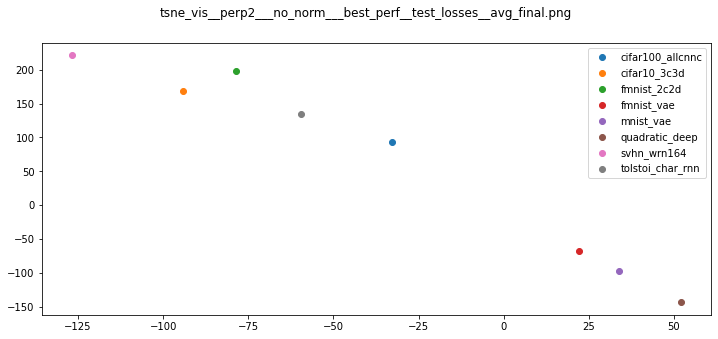

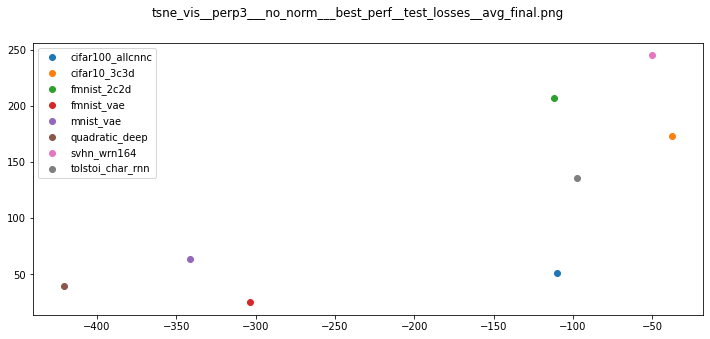

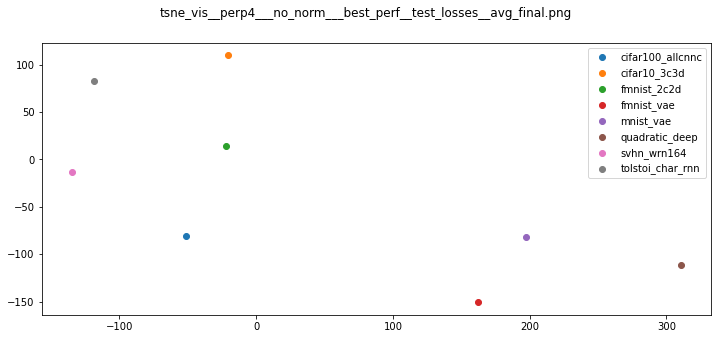

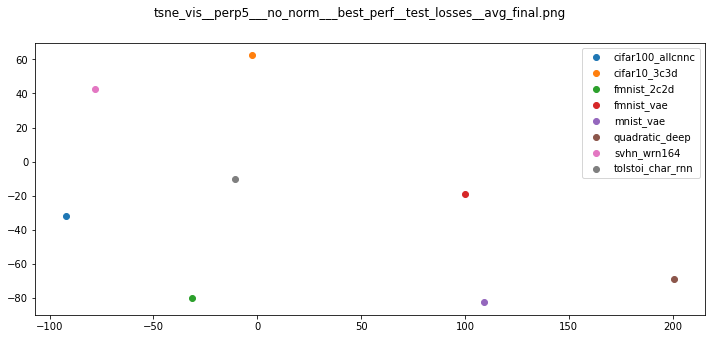

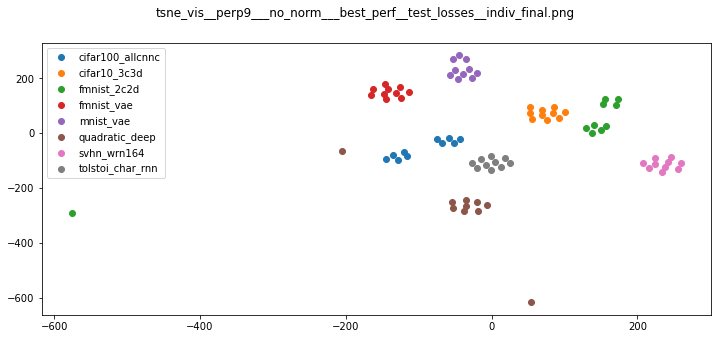

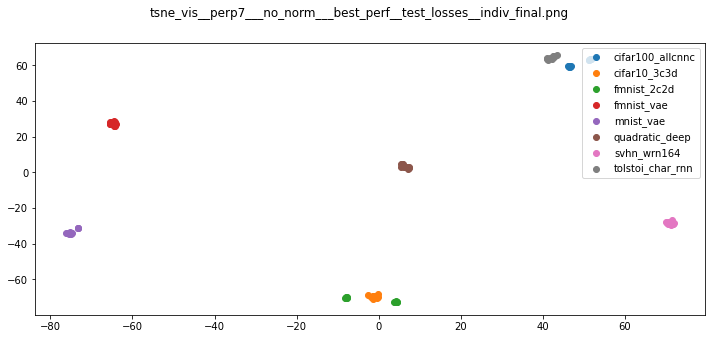

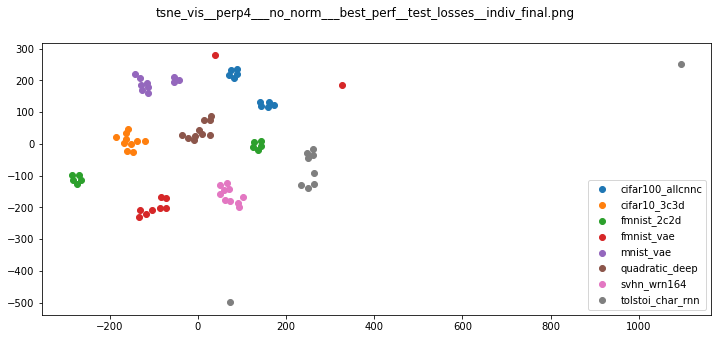

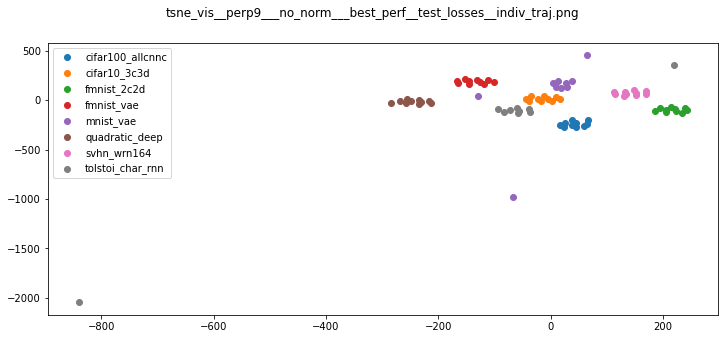

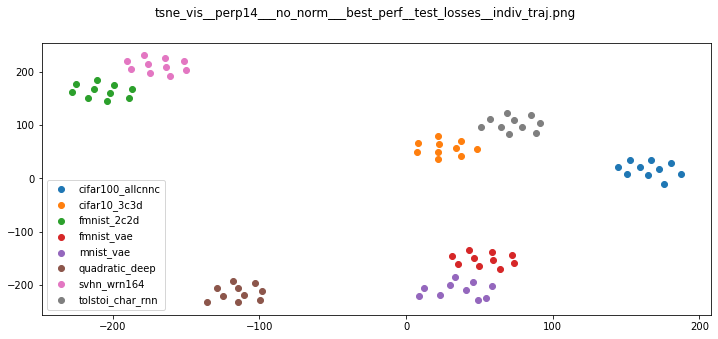

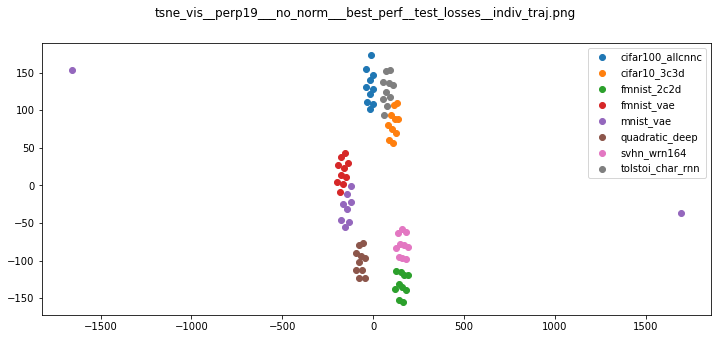

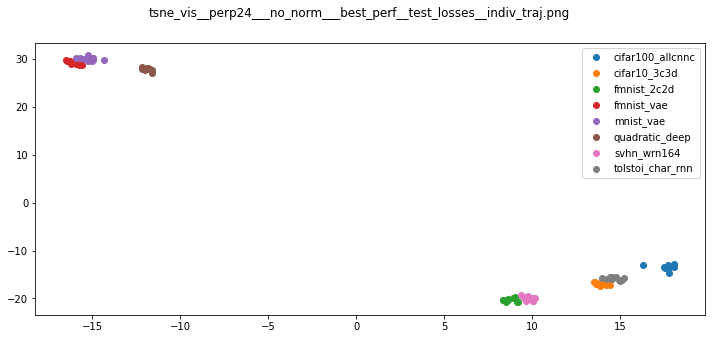

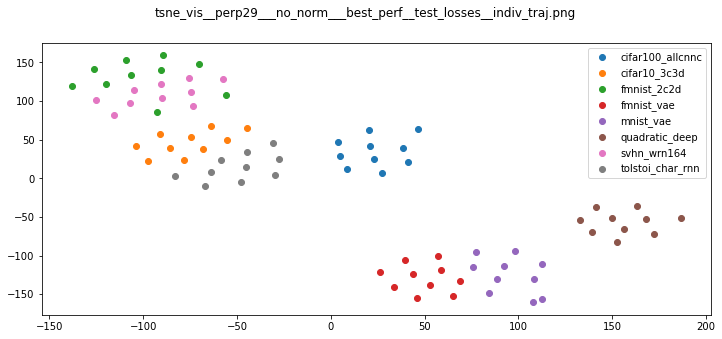

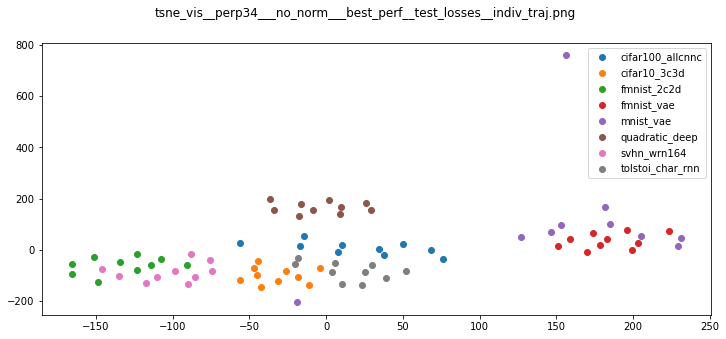

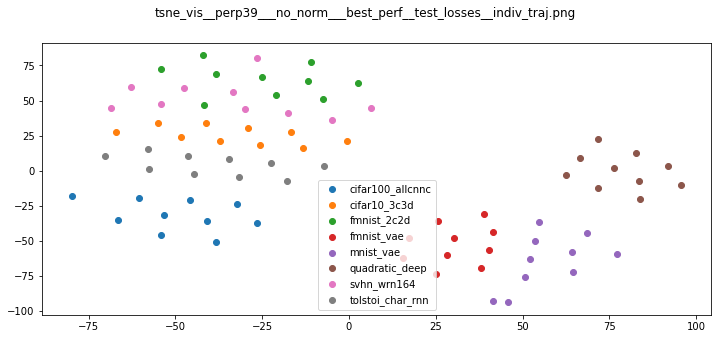

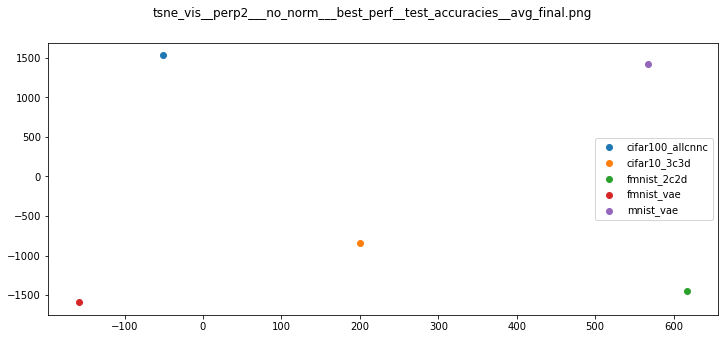

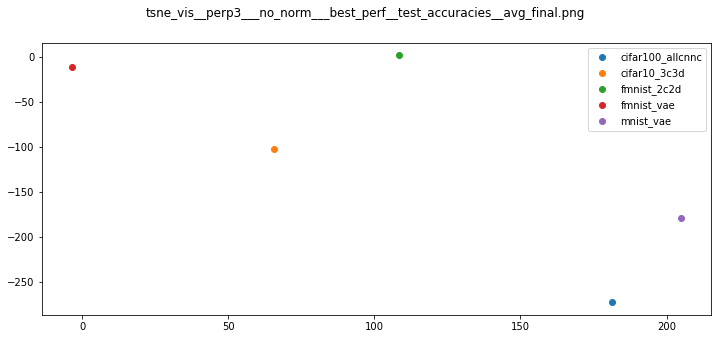

In [10]:
# construct TSNE instances with different numbers of clusters
def get_tsne_inst_list(perplexities):
    return [TSNE(perplexity=p, random_state=0) for p in perplexities]

tsne_for_indiv_traj_loss = get_tsne_inst_list(list(range(9, 44, 5)))
tsne_for_indiv_final_loss = get_tsne_inst_list([9, 7, 4])
tsne_for_avg_loss = get_tsne_inst_list([2, 3, 4, 5])
tsne_for_avg_acc = get_tsne_inst_list([2, 3])

for inst in tsne_for_avg_loss:
    get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", avg_final_test_loss_source, inst,
                    result_subdir="t-sne_visualization", save=True)
for inst in tsne_for_indiv_final_loss:
    get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", indiv_final_test_loss_source, inst,
                    result_subdir="t-sne_visualization", save=True)
for inst in tsne_for_indiv_traj_loss:
    get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", indiv_traj_test_loss_source, inst,
                    result_subdir="t-sne_visualization", save=True)
for inst in tsne_for_avg_acc:
    get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", avg_final_test_acc_source, inst,
                    result_subdir="t-sne_visualization", save=True)

In [11]:
# similarity without normalization
get_cdvy_result(calc_dist, "large_budget", "none", avg_final_test_loss_source, result_subdir="distance_similarity", save=True)
sim = get_cdvy_result(calc_dist, "large_budget", "none", avg_final_test_acc_source, result_subdir="distance_similarity", save=True)
sim

,cifar100_allcnnc,cifar10_3c3d,fmnist_2c2d,fmnist_vae,mnist_vae
cifar100_allcnnc,0.000000,1.243546,1.513588,1.701036,0.483866
cifar10_3c3d,1.243546,0.000000,0.432123,0.466672,0.820574
fmnist_2c2d,1.513588,0.432123,0.000000,0.459465,1.107202
fmnist_vae,1.701036,0.466672,0.459465,0.000000,1.286101
mnist_vae,0.483866,0.820574,1.107202,1.286101,0.000000


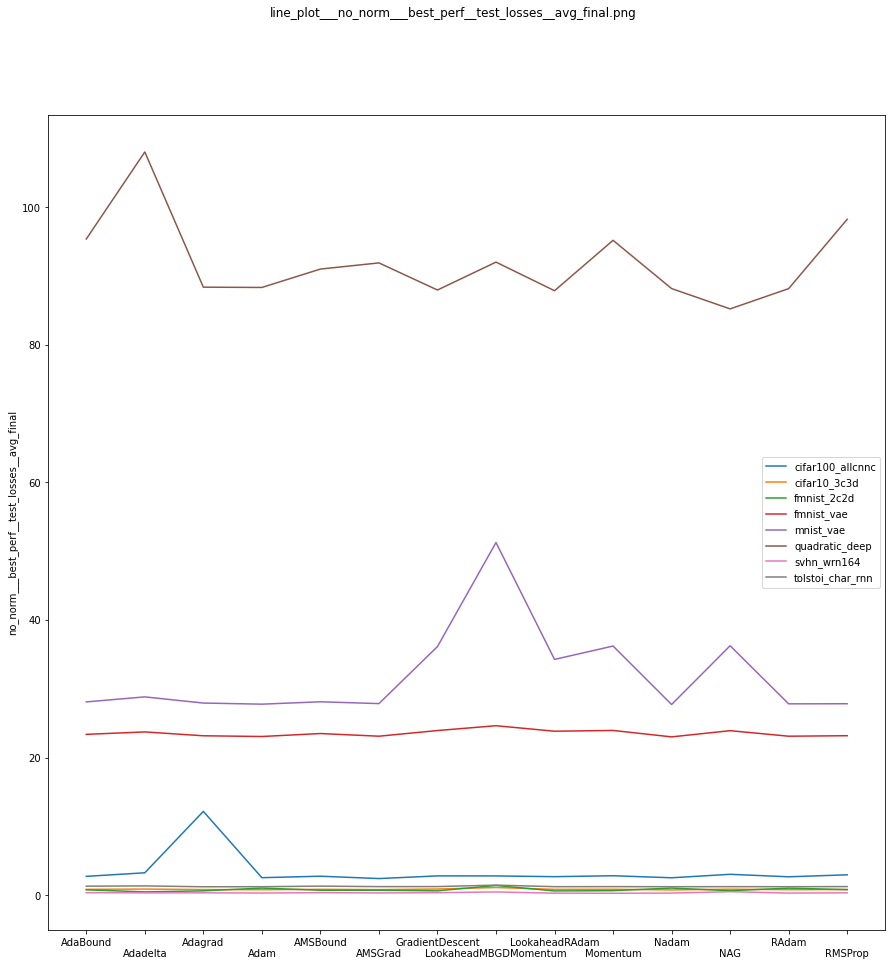

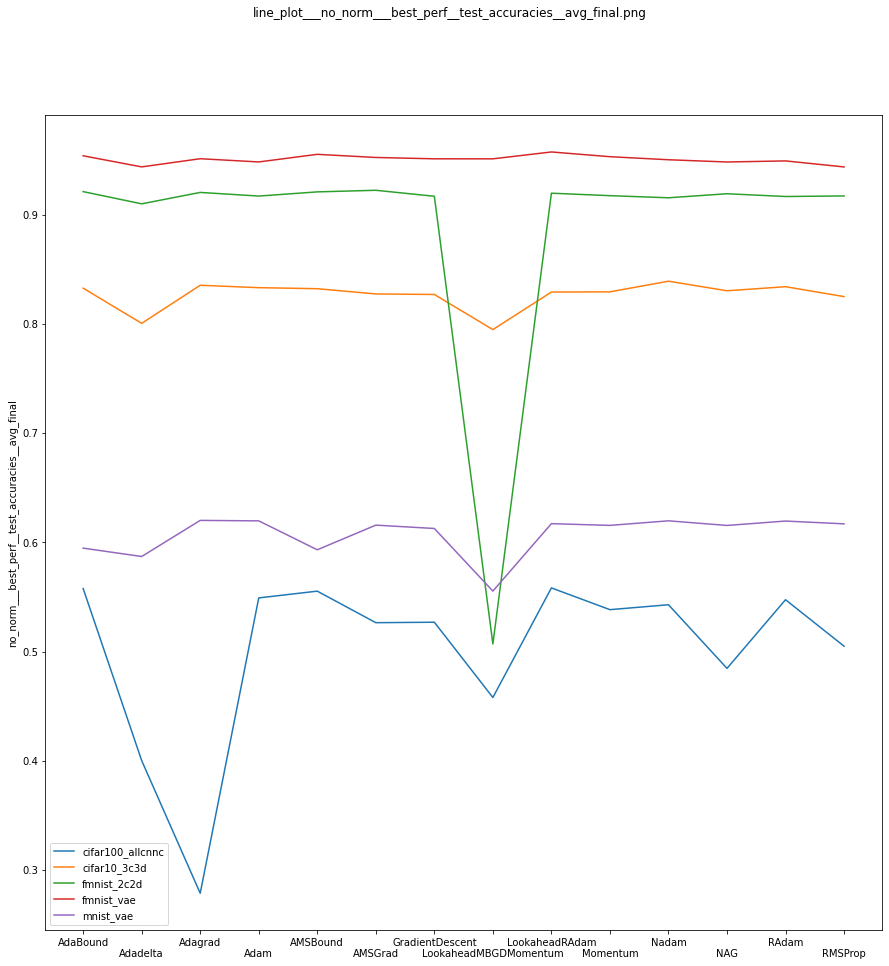

In [12]:
# line plots of performance without normalization
get_cdvy_result(plot_perf_vs_optims, "large_budget", "none", avg_final_test_loss_source, result_subdir="line_plots", save=True)
get_cdvy_result(plot_perf_vs_optims, "large_budget", "none", avg_final_test_acc_source, result_subdir="line_plots", save=True)

In [13]:
# normalize to euclidean norm 1
def np_euclid_norm(loss_array):
    num_rows = loss_array.shape[0]
    norm_array = np.reshape(np.linalg.norm(loss_array, axis=1), (num_rows, 1))
    return loss_array/norm_array

def euclid_norm(df, axis=1):
    return np_norm_func_wrapper(df, np_euclid_norm, axis)

get_cdvy_result(calc_dist, "large_budget", "none", avg_final_test_loss_source, norm_func=euclid_norm,
                result_subdir="distance_similarity", save=True)
# for inst in kmeans_for_avg:
#     get_cdvy_result(calc_clusters, "large_budget", "none", def_loss_source, inst, norm_func=euclid_norm, 
#                     result_subdir="clustering", save=True)
# for inst in kmeans_for_indiv:
#     get_cdvy_result(calc_clusters, "large_budget", "none", indiv_loss_source, inst, norm_func=euclid_norm, 
#                     result_subdir="clustering", save=True)

,cifar100_allcnnc,cifar10_3c3d,fmnist_2c2d,fmnist_vae,mnist_vae,quadratic_deep,svhn_wrn164,tolstoi_char_rnn
cifar100_allcnnc,0.000000,0.618577,0.711601,0.608207,0.657603,0.614127,0.624995,0.614926
cifar10_3c3d,0.618577,0.000000,0.263207,0.075347,0.120685,0.102745,0.134551,0.055179
fmnist_2c2d,0.711601,0.263207,0.000000,0.282385,0.267452,0.305708,0.296710,0.266357
fmnist_vae,0.608207,0.075347,0.282385,0.000000,0.180449,0.063259,0.163296,0.040142
mnist_vae,0.657603,0.120685,0.267452,0.180449,0.000000,0.214622,0.170225,0.171419
quadratic_deep,0.614127,0.102745,0.305708,0.063259,0.214622,0.000000,0.193074,0.061048
svhn_wrn164,0.624995,0.134551,0.296710,0.163296,0.170225,0.193074,0.000000,0.154170
tolstoi_char_rnn,0.614926,0.055179,0.266357,0.040142,0.171419,0.061048,0.154170,0.000000


In [14]:
# normalize by replacing performance with rank relative to other values in row 
def np_ranked(perf_array):
    num_rows = perf_array.shape[0]
    result_array = np.empty(perf_array.shape)
    sorted_array = np.sort(perf_array, axis=1)
    for row_ind in range(num_rows):
        for col_ind, val in enumerate(perf_array[row_ind]):
            result_array[row_ind][col_ind] = np.where(sorted_array[row_ind]==val)[0]
    return result_array

def ranked(df, axis=1):
    return np_norm_func_wrapper(df, np_ranked, axis)

get_cdvy_result(calc_dist, "large_budget", "none", avg_final_test_loss_source, norm_func=ranked,
                result_subdir="distance_similarity", save=True)
# for inst in kmeans_for_avg:
#     get_cdvy_result(calc_clusters, "large_budget", "none", def_loss_source, inst, norm_func=ranked, 
#                     result_subdir="clustering", save=True)
# for inst in kmeans_for_indiv:
#     get_cdvy_result(calc_clusters, "large_budget", "none", indiv_loss_source, inst, norm_func=ranked, 
#                     result_subdir="clustering", save=True)

,cifar100_allcnnc,cifar10_3c3d,fmnist_2c2d,fmnist_vae,mnist_vae,quadratic_deep,svhn_wrn164,tolstoi_char_rnn
cifar100_allcnnc,0.000000,13.564660,26.645825,14.696938,14.832397,18.547237,16.492423,18.867962
cifar10_3c3d,13.564660,0.000000,25.059928,5.477226,6.164414,19.339080,14.422205,10.583005
fmnist_2c2d,26.645825,25.059928,0.000000,25.019992,25.377155,20.297783,21.118712,21.771541
fmnist_vae,14.696938,5.477226,25.019992,0.000000,3.464102,20.639767,17.262677,13.564660
mnist_vae,14.832397,6.164414,25.377155,3.464102,0.000000,21.679483,16.309506,14.560220
quadratic_deep,18.547237,19.339080,20.297783,20.639767,21.679483,0.000000,20.688161,14.142136
svhn_wrn164,16.492423,14.422205,21.118712,17.262677,16.309506,20.688161,0.000000,14.832397
tolstoi_char_rnn,18.867962,10.583005,21.771541,13.564660,14.560220,14.142136,14.832397,0.000000


In [15]:
# subtract mean and normalize to euclidean norm 1 
def np_minus_mean_euclid_norm(loss_array):
    num_rows = loss_array.shape[0]
    mean = np.reshape(np.mean(loss_array, axis=1), (num_rows , 1))
    minus_mean = loss_array - mean
    norm_array = np.reshape(np.linalg.norm(minus_mean, axis=1), (num_rows, 1))
    return minus_mean/norm_array

def minus_mean_euclid_norm(df, axis=1):
    return np_norm_func_wrapper(df, np_minus_mean_euclid_norm, axis)

get_cdvy_result(calc_dist, "large_budget", "none", avg_final_test_loss_source, norm_func=minus_mean_euclid_norm,
                result_subdir="distance_similarity", save=True)
for inst in kmeans_for_avg_loss:
    df = get_cdvy_result(calc_clusters, "large_budget", "none", avg_final_test_loss_source, inst, 
                                      norm_func=minus_mean_euclid_norm, result_subdir="clustering", save=True)
for inst in kmeans_for_indiv_final_loss:
    for subset in opt_subsets:
        df = get_cdvy_result(calc_clusters, "large_budget", "none", indiv_final_test_loss_source, inst, 
                                      norm_func=minus_mean_euclid_norm, result_subdir="clustering", use_cols=subset, save=True)
df
# get_cdvy_result(plot_perf_vs_optims, "large_budget", "none", avg_final_test_loss_source, norm_func=minus_mean_euclid_norm, 
#                 result_subdir="line_plots", save=True)
# get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", avg_final_test_loss_source, t_sne, norm_func=minus_mean_euclid_norm, 
#                          result_subdir="t-sne_visualization", save=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cifar100_allcnnc,NaN,20.0,NaN,NaN,10.0,NaN,NaN,NaN,30.0,10.0,NaN,NaN,NaN,NaN,30.0,NaN
cifar10_3c3d,NaN,20.0,NaN,NaN,NaN,40.0,NaN,NaN,10.0,20.0,10.0,NaN,NaN,NaN,NaN,NaN
fmnist_2c2d,10.0,NaN,10.0,10.0,10.0,NaN,NaN,NaN,10.0,10.0,NaN,NaN,10.0,20.0,10.0,NaN
fmnist_vae,10.0,20.0,NaN,10.0,NaN,10.0,NaN,10.0,NaN,10.0,20.0,NaN,NaN,NaN,10.0,NaN
mnist_vae,NaN,NaN,10.0,50.0,10.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,10.0,NaN,10.0,NaN
quadratic_deep,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,NaN,NaN
svhn_wrn164,NaN,NaN,10.0,10.0,NaN,20.0,10.0,20.0,NaN,10.0,NaN,10.0,NaN,NaN,NaN,10.0
tolstoi_char_rnn,NaN,NaN,10.0,NaN,10.0,NaN,10.0,NaN,30.0,NaN,10.0,20.0,NaN,NaN,10.0,NaN


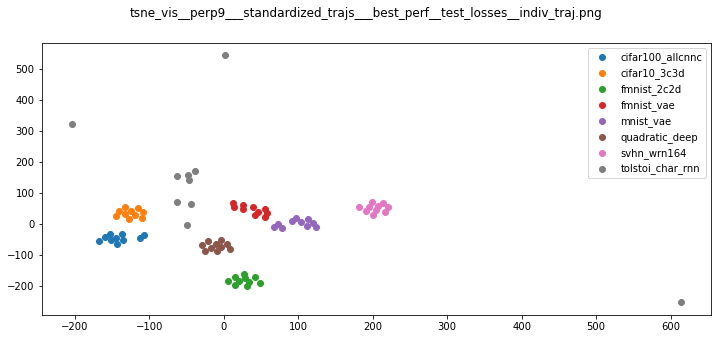

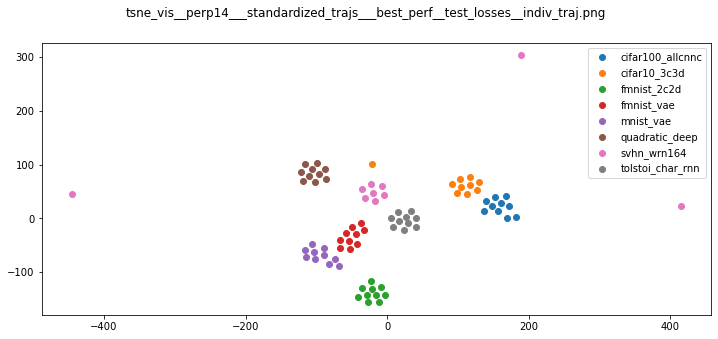

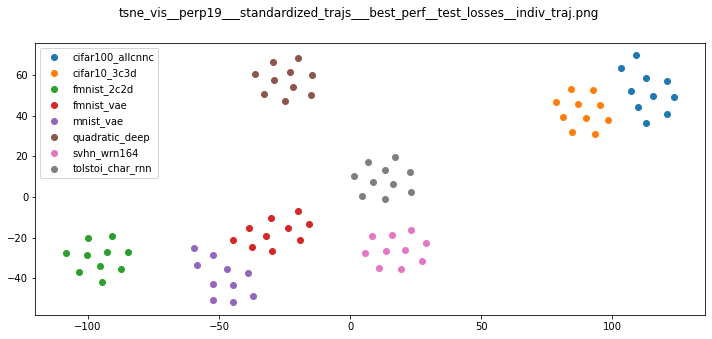

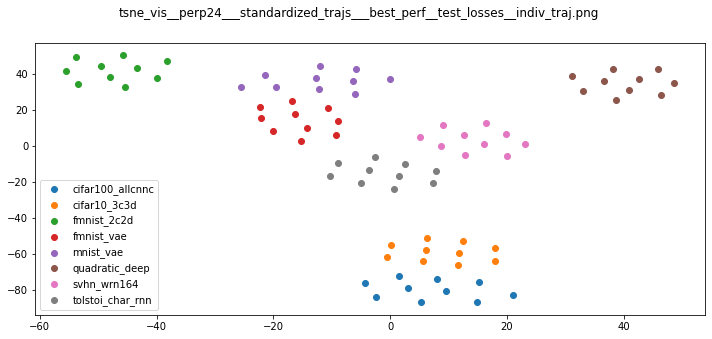

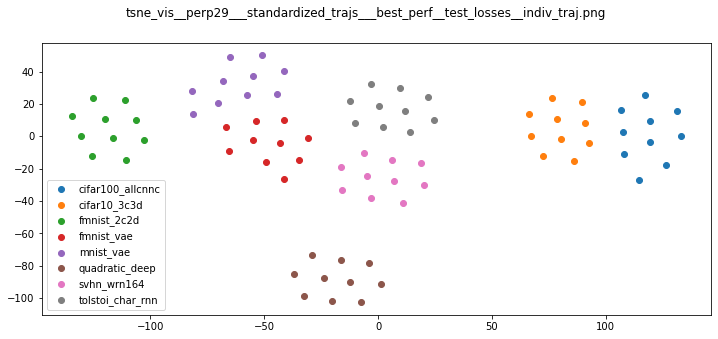

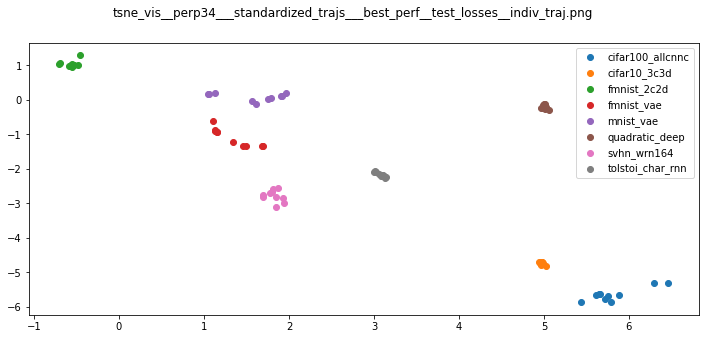

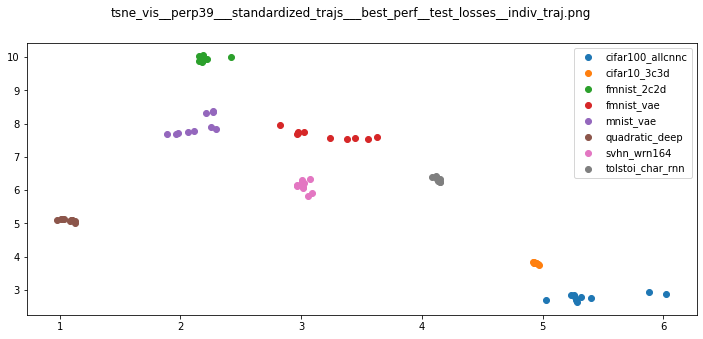

,0,1,2,3,4,5,6,7
cifar100_allcnnc,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN
cifar10_3c3d,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
fmnist_2c2d,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN
fmnist_vae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
mnist_vae,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
quadratic_deep,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
svhn_wrn164,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
tolstoi_char_rnn,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN


In [16]:
# get standardized DataFrame to check if the numbers are good
# get_cdvy_result(get_normed_df, "large_budget", "none", indiv_traj_test_loss_source, norm_func=standardized_trajs,  save=True)

# get euclidean similarity
get_cdvy_result(calc_dist, "large_budget", "none", indiv_traj_test_loss_source, norm_func=standardized_trajs,  save=True)

for inst in kmeans_for_indiv_traj_loss:
    for subset in opt_subsets:
        df = get_cdvy_result(calc_clusters, "large_budget", "none", indiv_traj_test_loss_source, inst, 
                                      norm_func=standardized_trajs, result_subdir="clustering", use_cols=subset, save=True)
# check which objectives merge first
for inst in kmeans_through_eight:
    for subset in [None, no_adagr_adadel]:
        df = get_cdvy_result(calc_clusters, "large_budget", "none", indiv_traj_test_loss_source, inst, 
                                      norm_func=standardized_trajs, result_subdir="clustering", use_cols=subset, save=True)

for inst in tsne_for_indiv_traj_loss:
    get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", indiv_traj_test_loss_source, inst,
                    norm_func=standardized_trajs, result_subdir="t-sne_visualization", save=True)

df

In [17]:
unit_curve_scale = lambda curve: linear_curve_scale(curve, 0, 1)

def traj_frechet_no_scale(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, frechet_dist, summary_func=np.max)

def traj_frechet_unit_scale(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, frechet_dist, curve_scale_func=unit_curve_scale,
                             summary_func=np.max)

def traj_frechet_square_scale(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, frechet_dist, curve_scale_func=linear_curve_scale,
                             summary_func=np.max)

def traj_dtw_wrapper(scaled_traj_i, scaled_traj_j):
    """ Seems like dimensions need to be swapped for dtw according to this statement:
    "[dtw_ndim.distance] assumes the first dimension to be the sequence item index,
    and the second dimension to be the series index (thus timestep)." """
    swapped_i = np.array([(y, x) for (x, y) in scaled_traj_i])
    swapped_j = np.array([(y, x) for (x, y) in scaled_traj_j])
    return dtw_ndim.distance(swapped_i, swapped_j)

def traj_dtw_no_scale(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, traj_dtw_wrapper)

def traj_dtw_unit_scale(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, traj_dtw_wrapper, curve_scale_func=unit_curve_scale)

def traj_dtw_square_scale(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, traj_dtw_wrapper, curve_scale_func=linear_curve_scale)

def traj_dtw_1dim(traj_i, traj_j):
    return traj_dist_summary(traj_i, traj_j, dtw.distance)


first_run = {1: {INC_KEY: "seed_42"}}

# use for testing dropping from multiple level of same index
# first_run_only_tolstoi = {0: {INC_KEY:"tolstoi_char_rnn"}, **first_run}

use_rows_options = [first_run, None]
# use_rows_options = [first_run]

use_cols_options = [no_adagr_adadel, None]
# use_cols_options = [no_adagr_adadel]

# use_dist_funcs = [traj_frechet_no_scale, traj_frechet_unit_scale, traj_frechet_square_scale,
#                   traj_dtw_no_scale, traj_dtw_unit_scale, traj_dtw_square_scale]

# use_dist_funcs = [traj_dtw_no_scale, traj_dtw_unit_scale, traj_dtw_square_scale]

use_dist_funcs = [traj_dtw_1dim]

# for use_rows in use_rows_options:
#     for use_cols in use_cols_options:
#         for dist_func in use_dist_funcs:
#             get_cdvy_result(calc_dist, "large_budget", "none", indiv_traj_test_loss_source, norm_func=standardized_trajs,
#                             dist_func=dist_func, use_rows=use_rows, use_cols=use_cols,
#                             result_subdir="distance_similarity", save=True)


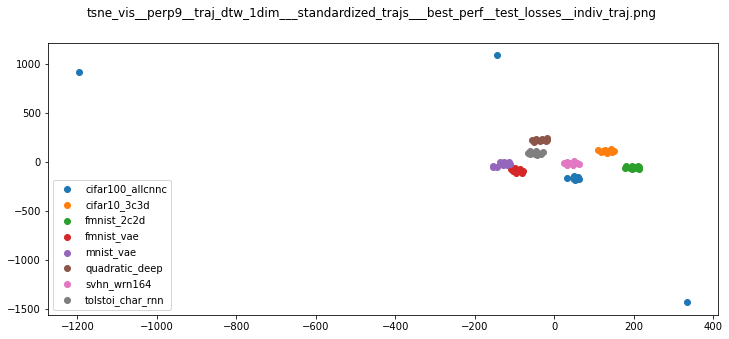

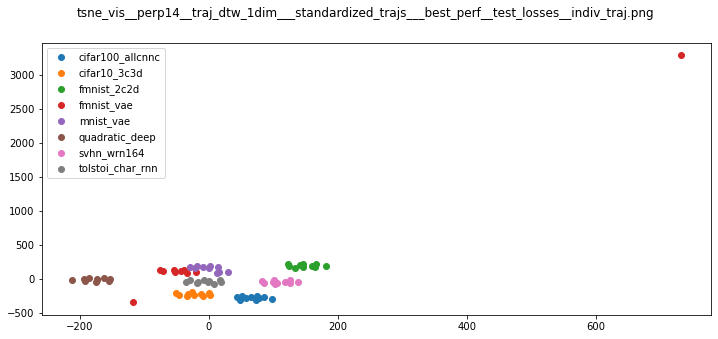

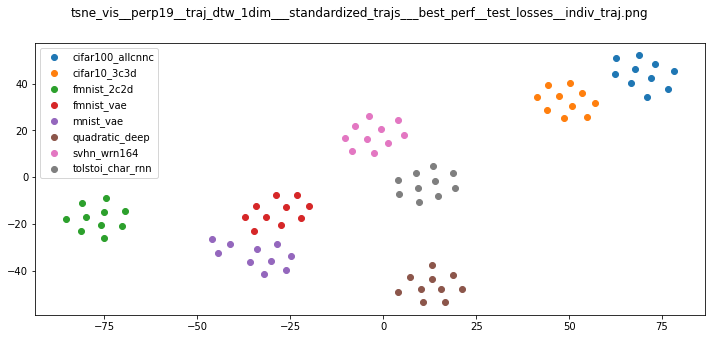

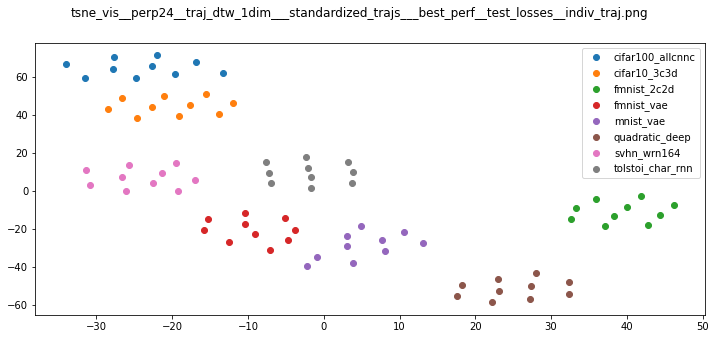

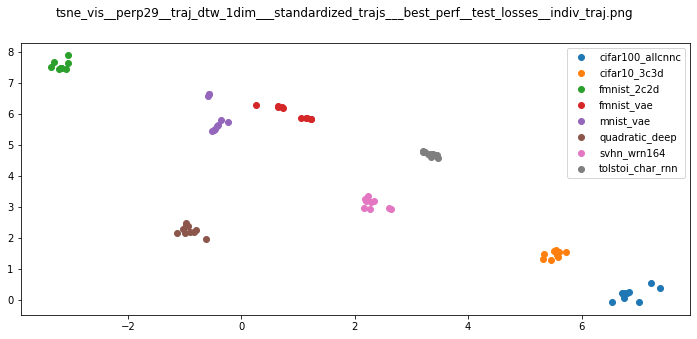

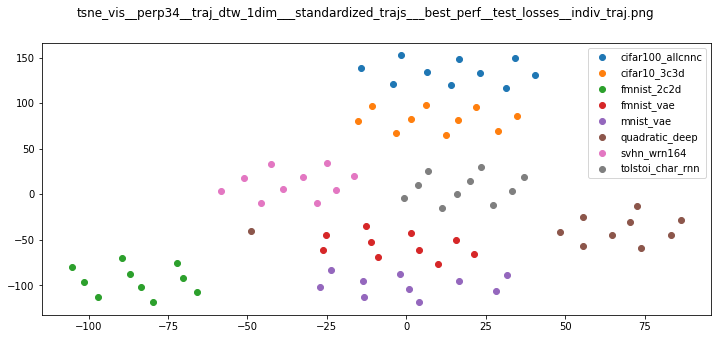

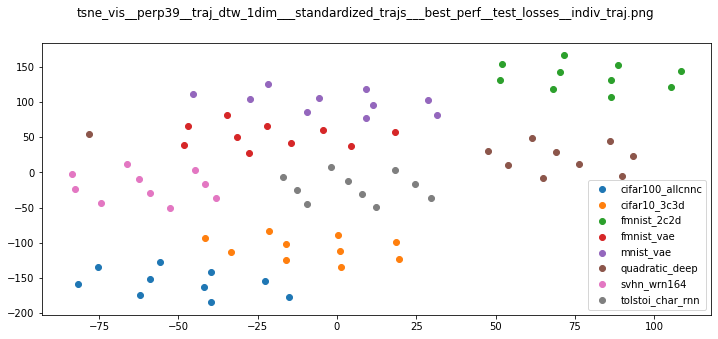

In [18]:
for dist_func in use_dist_funcs:
    for inst in tsne_for_indiv_traj_loss:
        get_cdvy_result(tsne_vis_perf_array,"large_budget", "none", indiv_traj_test_loss_source, inst,
                        norm_func=standardized_trajs,
                        dist_dir="distance_similarity",
                        df_dep_dist_func=dist_func,
                        result_subdir="t-sne_visualization", save=True)

In [19]:
# np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)
# get_cdvy_result(plot_all_traj_dtw, "large_budget", "none", indiv_traj_test_loss_source, norm_func=standardized_trajs,
#                 use_rows=None, use_cols=None, result_subdir="dtw_plots", save=True)

In [20]:
indiv_traj_test_loss_path = os.path.join(".", "Crowded_Valley_results", "large_budget", "none", indiv_traj_test_loss_source)
indiv_traj_train_loss_path = os.path.join(".", "Crowded_Valley_results", "large_budget", "none", indiv_traj_train_loss_source)
df = get_normed_df([indiv_traj_test_loss_path, indiv_traj_train_loss_path])
df

optim                    AMSBoundOptimizer                                \
epoch                                    0         1         2         3   
obj              runSeed                                                   
cifar100_allcnnc seed_42          4.923562  4.684223  4.567289  4.379273   
                 seed_43          4.925018  4.610175  4.428798  4.319539   
                 seed_44          4.929370  4.684861  4.545687  4.359150   
                 seed_45          4.925267  4.638780  4.453150  4.354273   
                 seed_46          4.922133  4.633562  4.502531  4.329575   
...                                    ...       ...       ...       ...   
tolstoi_char_rnn seed_47          4.394773  2.461179  2.216448  2.091097   
                 seed_48          4.392507  2.459730  2.231448  2.119067   
                 seed_49          4.404280  2.512654  2.246233  2.134494   
                 seed_50          4.443937  2.489638  2.243228  2.115635   
                 seed_51          4.377913  2.497926  2.228619  2.111391   

optim                                                                       \
epoch                            4         5         6         7         8   
obj              runSeed                                                     
cifar100_allcnnc seed_42  4.233482  4.135238  4.019717  3.892258  3.967606   
                 seed_43  4.193270  4.065817  3.975177  3.835729  3.724429   
                 seed_44  4.252972  4.144398  3.986247  3.917609  3.789544   
                 seed_45  4.310877  4.205590  4.042065  3.907383  3.818518   
                 seed_46  4.151993  4.042247  3.942598  3.822452  3.789074   
...                            ...       ...       ...       ...       ...   
tolstoi_char_rnn seed_47  2.007702  1.948576  1.887556  1.856001  1.816546   
                 seed_48  2.032772  1.966808  1.910894  1.864169  1.835104   
                 seed_49  2.040499  1.969553  1.911606  1.866579  1.827980   
                 seed_50  2.021861  1.954065  1.897914  1.854139  1.817335   
                 seed_51  2.028165  1.955720  1.902260  1.855434  1.824107   

optim                               ... RMSPropOptimizer                      \
epoch                            9  ...              341       342       343   
obj              runSeed            ...                                        
cifar100_allcnnc seed_42  3.728882  ...         3.116842  3.180217  2.988039   
                 seed_43  3.703413  ...         2.645114  2.946001  2.836172   
                 seed_44  3.718714  ...         3.067200  3.168075  2.828888   
                 seed_45  3.696601  ...         2.967575  2.938335  2.717858   
                 seed_46  3.645084  ...         2.774922  2.973830  2.682950   
...                            ...  ...              ...       ...       ...   
tolstoi_char_rnn seed_47  1.775195  ...              NaN       NaN       NaN   
                 seed_48  1.802833  ...              NaN       NaN       NaN   
                 seed_49  1.798368  ...              NaN       NaN       NaN   
                 seed_50  1.788945  ...              NaN       NaN       NaN   
                 seed_51  1.780905  ...              NaN       NaN       NaN   

optim                                                                       \
epoch                          344       345       346       347       348   
obj              runSeed                                                     
cifar100_allcnnc seed_42  3.025639  3.226125  2.929218  2.967104  2.850203   
                 seed_43  2.849379  2.706638  2.891237  3.076683  2.766991   
                 seed_44  3.007643  2.960445  2.953903  2.861018  2.988977   
                 seed_45  3.027416  2.715303  3.010239  2.678573  3.036694   
                 seed_46  2.892072  2.711046  2.918170  2.812736  2.644997   
...                            ...       ...       ...       ...       ...   
tolstoi_char_rnn se